In [10]:
import os
import matplotlib.pyplot as plt
import numpy as np
from orix.quaternion import Rotation
from pathlib import Path
import kikuchipy as kp
from openECCI import util, io, rkp, stagecomputation

plt.rcParams.update({
    "figure.figsize": (7, 7),
    "font.size": 9,
})

In [11]:
optimized_correction_coefficients = {'tiltX_corr_angle': -0.41774066903384044, 'tiltY_corr_angle': 1.8230566479229673, 'tiltZ_corr_angle': 0.021146726033788282, 'PCz': 3.8888298036068742}

In [12]:
# Path to Si ECP reference pattern
si_ref_ecp_path = r"D:\OneDrive - Monash University\2018-2019 MCEM\02 Projects\13 EBSD n ECCI\20221219 EBSD steel Si tilt"
si_ref_ecp_file = r"Si_0tilt_0rot_008.tif"
si_ref_ecp_fname = os.path.join(si_ref_ecp_path, si_ref_ecp_file)
ref_ecp = plt.imread(si_ref_ecp_fname)


# Path to Si master pattern generated by EMsoft
si_MP_path = Path(r"C:\Users\IMBalENce\EMsoftData")
si_MP_file = r"Si-master-20kv.h5"
si_MP_fname = os.path.join(si_MP_path, si_MP_file)
si_ECP_MP = kp.load(si_MP_fname, projection="lambert", hemisphere="both", energy=20)

# Path to Si .ctf file containing the EBSD euler angles
si_xmap_path = r"D:\OneDrive - Monash University\2018-2019 MCEM\02 Projects\13 EBSD n ECCI\20221216 EBSD standard steel\standard steel sample 14_12_2022\standard fcc steel"
si_xmap_file = r"20kv_26nA_15mm WD_4x4 binning Si Map Data 2.ctf"
si_xmap_fname = os.path.join(si_xmap_path, si_xmap_file)

In [13]:
# Path to Si ECP experimental pattern
si_exp_ecp_path = r"D:\OneDrive - Monash University\2018-2019 MCEM\02 Projects\13 EBSD n ECCI\20221219 EBSD steel Si tilt"
si_exp_ecp_file = r"Si_5tilt_0rot_004.tif"
si_exp_ecp_fname = os.path.join(si_exp_ecp_path, si_exp_ecp_file)
experiment_ecp = plt.imread(si_exp_ecp_fname)

stage rotation: 0.0, stage tilt: 5.0


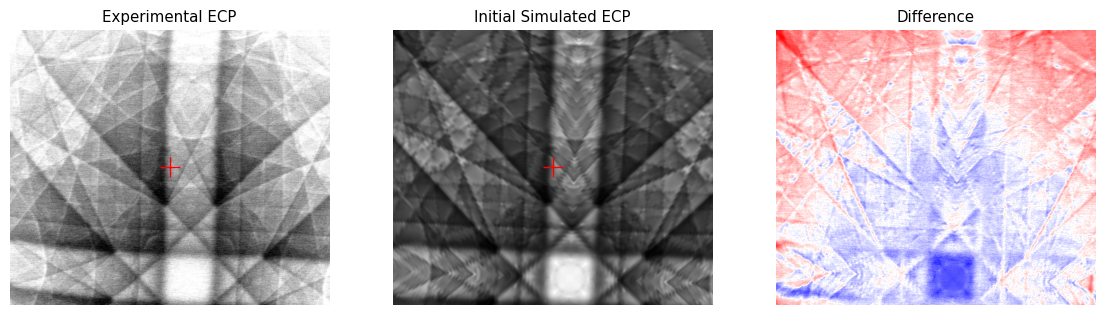

In [14]:
%matplotlib inline
# Get a approximate guess on the optimization parameters
tiltX_corr_angle_op = optimized_correction_coefficients["tiltX_corr_angle"] # positive direction => pattern moves DOWN
tiltY_corr_angle_op = optimized_correction_coefficients["tiltY_corr_angle"] # positive direction => pattern moves LEFT
tiltZ_corr_angle_op = optimized_correction_coefficients["tiltZ_corr_angle"] # positive direction => pattern rotates COUNTER-CLOCKWISE
PCz_op = optimized_correction_coefficients["PCz"] # Larger value => smaller angular range

# get the stage rotation and tilt relative to the reference ECP
# angles used here are according to the testing reference frame rather than the SEM software rotation and tilt
st_rot_angle, st_tilt_angle = stagecomputation.get_relative_stage_pos(si_ref_ecp_fname, si_exp_ecp_fname)

# convert the stage rotation and tilt to Rotation objects
# the negative sign is used because the stage rotation and tilt active rotations. 
# In EBSD, rotations are usually in passive form according to Bunge convention
st_rot = Rotation.from_axes_angles(axes = [0, 0, 1], 
                                   angles = -st_rot_angle, 
                                   degrees = True)
st_tilt = Rotation.from_axes_angles(axes = [0, 1, 0], 
                                    angles = -st_tilt_angle, 
                                    degrees=True)

# read the average orientation of Si EBSD map
# si_average_rotation = get_avg_orientation(si_xmap_fname) * Rotation.from_axes_angles([0, 0, 1], -np.pi / 2)
si_average_rotation = io.get_avg_orientation(si_xmap_fname)
ecp_resolution = io.get_sem_metadata(si_ref_ecp_fname)["resolution"]

# simulate the ECP using the initial guess
sim_RKP = rkp.get_sim_rkp(RKP_masterpattern = si_ECP_MP,
                              xtal_rotation = si_average_rotation,
                              st_rot_angle = st_rot_angle,
                              st_tilt_angle = st_tilt_angle,
                              corr_angles=[tiltX_corr_angle_op, tiltY_corr_angle_op, tiltZ_corr_angle_op],
                              ref_ECP=si_ref_ecp_fname,
                              cam_length=PCz_op,
                              RKP_shape=ecp_resolution)

fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,6))
ax1.imshow(experiment_ecp[:ecp_resolution[1],:], cmap='gray')
ax1.plot(ecp_resolution[0]//2, ecp_resolution[1]//2, 'r+', markersize=14)
ax1.set_title("Experimental ECP")
ax1.axis("off")

ax2.imshow(np.squeeze(sim_RKP.data), cmap='gray')
ax2.plot(ecp_resolution[0]//2, ecp_resolution[1]//2, 'r+', markersize=14)
ax2.set_title("Initial Simulated ECP")
ax2.axis("off")

ax3.imshow(util.normalize(experiment_ecp[:ecp_resolution[1],:]) - util.normalize(np.squeeze(sim_RKP.data)), cmap='bwr')
ax3.set_title("Difference")
ax3.axis("off")

print(f"stage rotation: {np.round(st_rot_angle, 2)}, stage tilt: {np.round(st_tilt_angle, 2)}")